# Comparison of Identification of Dimensionality Reduction Techniques for Unified Free Energy Surfaces
Big question:  What is the best way to create FESs in which you can compare similar but distinct systems?  How do you find the best shared basis for FES comparison?

Simulations: 3x alanine dipeptide, 3x alanine valine, 3x alanine glycine (essentially both are slightly modified alanine dipeptide)

Comparison: 

Do dimensionality reduction (unified system) with

DMap

VAMPnet (this shouldn’t really work properly—or should it?)

GMVAE

(Mesa?)

We know this should be a 2D system, so don’t worry about spectral gap

Compare correlations between each one and ground truth

Compare correlations between each other

Compare what you get if you do them separately versus unified

## Imports

In [1]:
import sys

import numpy as np
import itertools
import os
import time


import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

import pandas as pd
import pyemma
import mdtraj
import nglview as nv #conda install nglview -c conda-forge

from scipy.stats import kurtosis
from sklearn.preprocessing import StandardScaler



In [2]:
import tensorflow as tf
sys.path.append('gmvae')
from model import GMVAE
from dataset import load_and_mix_data_nolabel

matplotlib.rcParams.update({'font.size': 24})

## Load Data


In [3]:
sims = ['ala','gly','val']
simno = 1
fstem = 'md_fit_'
gros = []
xtcs = []
for i in sims:
    for j in range(simno):
        gros += [fstem+i+str(j+1)+'.gro']
        xtcs += [fstem+i+str(j+1)+'.xtc']

In [4]:
gros

['md_fit_ala1.gro', 'md_fit_gly1.gro', 'md_fit_val1.gro']

In [5]:
feat = pyemma.coordinates.featurizer(gros[2])
feat.add_backbone_torsions(periodic=False)
feat.add_distances(feat.select_Heavy(),periodic=False)
data = pyemma.coordinates.load(xtcs[2], features=feat)

08-04-22 12:01:42 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[0] WARNING  The 1D arrays input for add_distances() have been sorted, and index duplicates have been eliminated.
Check the output of describe() to see the actual order of the features


In [6]:
len(feat.describe())

68

In [7]:
view = nv.show_mdtraj(mdtraj.load(xtcs[0],top=gros[0]))
view

NGLWidget(max_frame=25022)

In [8]:
view = nv.show_mdtraj(mdtraj.load(xtcs[1],top=gros[1]))
view

NGLWidget(max_frame=25000)

In [9]:
view = nv.show_mdtraj(mdtraj.load(xtcs[2],top=gros[2]))
view

NGLWidget(max_frame=25000)

These things of course don't have the same number of atoms. They match, however, apart from the side chain of the middle residue. So we want to pull heavy atoms for the ACE and the NME and then carbon alpha from the middle residue.  What does this selection look like?

In [10]:
selstring = 'resid 0 and not type H or resid 2 and not type H or resid 1 and backbone'
selinds = [mdtraj.load(gros[i])[0].topology.select(selstring) for i in range(len(gros))]
selinds

[array([ 0,  4,  5,  6,  8, 14, 15, 16, 18]),
 array([ 0,  4,  5,  6,  8, 11, 12, 13, 15]),
 array([ 0,  4,  5,  6,  8, 20, 21, 22, 24])]

In [11]:
#create a torsion data set and a heavy atom distance dataset
tfeats = []
tdatas = []
hfeats = []
hdatas = []
for i in range(len(gros)):
    tfeat = pyemma.coordinates.featurizer(gros[i])
    hfeat = pyemma.coordinates.featurizer(gros[i])
    tfeat.add_backbone_torsions(periodic=False)
    hfeat.add_distances(selinds[i],periodic=False)
    print(len(hfeat.describe()))
    tfeats.append(tfeat)
    hfeats.append(hfeat)
    tdata = pyemma.coordinates.load(xtcs[i], features=tfeat)
    tdatas.append(tdata)
    hdata = pyemma.coordinates.load(xtcs[i], features=hfeat)
    hdatas.append(hdata)

08-04-22 12:03:14 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[2] WARNING  The 1D arrays input for add_distances() have been sorted, and index duplicates have been eliminated.
Check the output of describe() to see the actual order of the features
36
08-04-22 12:03:15 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[5] WARNING  The 1D arrays input for add_distances() have been sorted, and index duplicates have been eliminated.
Check the output of describe() to see the actual order of the features
36
08-04-22 12:03:15 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[8] WARNING  The 1D arrays input for add_distances() have been sorted, and index duplicates have been eliminated.
Check the output of describe() to see the actual order of the features
36


Okay, now we have the same number of input descriptors for each peptide and we can visualize those suckers.

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:xlabel='Feature values', ylabel='Feature histograms'>)

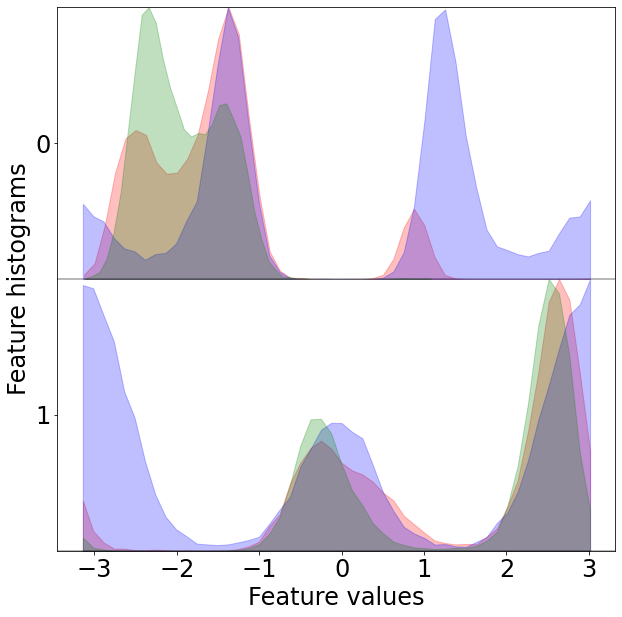

In [13]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
pyemma.plots.plot_feature_histograms(tdatas[0][::1,:2],ax=ax,color='r')
pyemma.plots.plot_feature_histograms(tdatas[1][::1,:2],ax=ax,color='b')
pyemma.plots.plot_feature_histograms(tdatas[2][::1,:2],ax=ax,color='g')

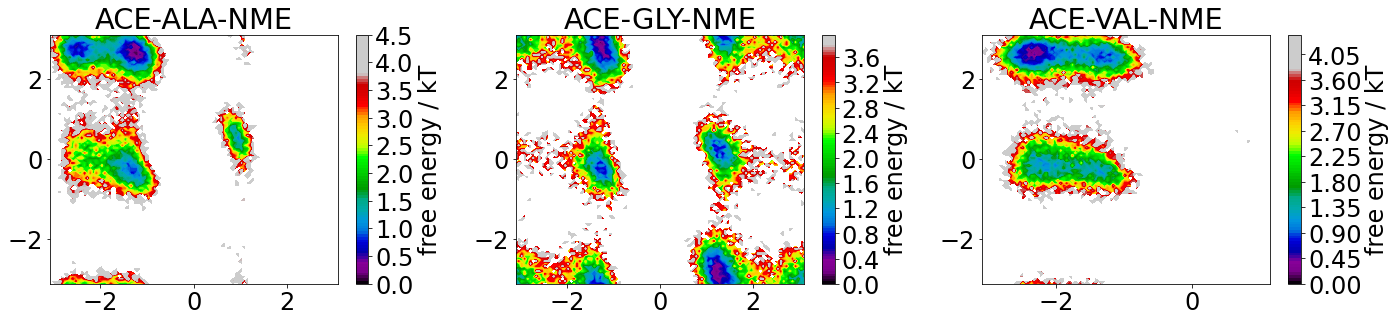

In [14]:
fig,axes = plt.subplots(1,3,figsize=(20,5))
pyemma.plots.plot_free_energy(tdatas[0][:,0],tdatas[0][:,1],ax=axes[0],vmax=3.8,vmin=0)
pyemma.plots.plot_free_energy(tdatas[1][:,0],tdatas[1][:,1],ax=axes[1],vmax=3.8,vmin=0)
pyemma.plots.plot_free_energy(tdatas[2][:,0],tdatas[2][:,1],ax=axes[2],vmax=3.8,vmin=0)
axes[0].set_title('ACE-ALA-NME')
axes[1].set_title('ACE-GLY-NME')
axes[2].set_title('ACE-VAL-NME')
plt.tight_layout()

The alanine dipeptide one looks "normal", the one with much less steric hindrance has a shallower landscape and more metastable states, and the one with more steric hindrance is similar but more funneled, so this makes some sense, at least.

In [13]:
help(pyemma.coordinates.vamp)

Help on function vamp in module pyemma.coordinates.api:

vamp(data=None, lag=10, dim=None, scaling=None, right=False, ncov_max=inf, stride=1, skip=0, chunksize=None)
    Variational approach for Markov processes (VAMP) [1]_.
    
    Parameters
    ----------
    lag : int
        lag time
    dim : float or int, default=None
        Number of dimensions to keep:
    
        * if dim is not set (None) all available ranks are kept:
            `n_components == min(n_samples, n_uncorrelated_features)`
        * if dim is an integer >= 1, this number specifies the number
          of dimensions to keep.
        * if dim is a float with ``0 < dim < 1``, select the number
          of dimensions such that the amount of kinetic variance
          that needs to be explained is greater than the percentage
          specified by dim.
    scaling : None or string
        Scaling to be applied to the VAMP order parameters upon transformation
    
        * None: no scaling will be applied, varia

In [15]:
tscores = []
hscores = []
for i in range(len(gros)):
    vamp = pyemma.coordinates.vamp(tdatas[i],lag=5,dim=2)
    tscores.append(vamp.score(tdatas[i]))
    vamp = pyemma.coordinates.vamp(hdatas[i],lag=5,dim=2)
    hscores.append(vamp.score(hdatas[i]))

In [16]:
tscores

[1.4424444450986198, 1.0064019667745936, 1.5003137163666755]

In [17]:
hscores

[1.2727641416678388, 1.0635222367613564, 1.7038175845691717]

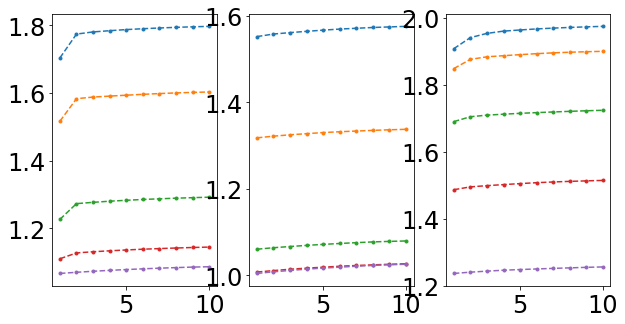

In [18]:
lags = [1,2,5,10,20]
dims = [i+1 for i in range(10)]
fig,axes = plt.subplots(1,3,figsize=(10,5))
for i in range(len(gros)):
    for lag in lags:
        scores = []
        for dim in dims:
            vamp = pyemma.coordinates.vamp(hdatas[i],lag=lag,dim=dim)
            scores.append(vamp.score(hdatas[i]))
        axes[i].plot(dims,scores,'.--')
        

So we're seeing probably 1-2 dimensions (heuristically and currently without error bars; most pronounced for the original alanine, least pronounced for the non-sterically-hindered glycine, which makes sense)

So...we need to identify reaction coordinates.  From what we have here, we're seeing probably a 2D description (as expected), and we're pretending we just use the heavy atom distances to see if we can extract something similar to the dihedrals (might have to fold those in, though...or use the heavy atom coordinates instead?)  Available methods for extraction:
- unified DMap
- GMVAE
- TICA/Vampnets (this should not work, we think, because it depends on time)

After identifying reaction coordinates, we can construct a FES (which should look like the one above) and then perhaps train an FES.

In [19]:
import PyDMap
import pyemma
import mdtraj
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'PyDMap'

In [19]:
selinds

[array([ 0,  4,  5,  6,  8, 14, 15, 16, 18]),
 array([ 0,  4,  5,  6,  8, 11, 12, 13, 15]),
 array([ 0,  4,  5,  6,  8, 20, 21, 22, 24])]

In [190]:
trajs = [mdtraj.load(xtcs[i],top=gros[i])[0:25000:100].center_coordinates() for i in range(len(gros))]

In [191]:
trajs

[<mdtraj.Trajectory with 250 frames, 22 atoms, 3 residues, and unitcells at 0x7fd0a9ee35e0>,
 <mdtraj.Trajectory with 250 frames, 19 atoms, 3 residues, and unitcells at 0x7fd0a9ee8160>,
 <mdtraj.Trajectory with 250 frames, 28 atoms, 3 residues, and unitcells at 0x7fd0a9ee8250>]

In [175]:
len(trajs[0].topology.select("resid 2 and not type H"))

2

In [189]:
for s in trajs[0].topology.select("backbone"):
    print(trajs[0].topology.atom(s))

ACE1-C
ACE1-O
ALA2-N
ALA2-CA
ALA2-C
ALA2-O
NME3-N
NME3-C


In [187]:
for s in selinds[0]:
    print(trajs[0].topology.atom(s))
for s in selinds[1]:
    print(trajs[1].topology.atom(s))
for s in selinds[2]:
    print(trajs[2].topology.atom(s))

ACE1-CH3
ACE1-C
ACE1-O
ALA2-N
ALA2-CA
ALA2-C
ALA2-O
NME3-N
NME3-C
ACE1-CH3
ACE1-C
ACE1-O
GLY2-N
GLY2-CA
GLY2-C
GLY2-O
NME3-N
NME3-C
ACE1-CH3
ACE1-C
ACE1-O
VAL2-N
VAL2-CA
VAL2-C
VAL2-O
NME3-N
NME3-C


In [63]:
trajs

[<mdtraj.Trajectory with 2500 frames, 22 atoms, 3 residues, and unitcells at 0x7fd19da71340>,
 <mdtraj.Trajectory with 2500 frames, 19 atoms, 3 residues, and unitcells at 0x7fd19da6cd00>,
 <mdtraj.Trajectory with 2500 frames, 28 atoms, 3 residues, and unitcells at 0x7fd19da63e20>]

In [192]:
#grab rmsd to reference structure
#note that this is slightly different from rmsd between two optimally aligned conformations
#however it is still justifiable as a dynamical distance

import time
start = time.time()
RMSD = np.zeros((3*len(trajs[0]),3*len(trajs[0])))
Fn = len(trajs[0])
for i in range(3):
    for j in range(len(trajs[0])):
    
        refi = Fn*i+j
        for k in range(3):
            rmsd = mdtraj.rmsd(trajs[i],trajs[k],frame=j,atom_indices=selinds[i],ref_atom_indices=selinds[k])
            RMSD[refi,(Fn*k):(Fn*k+Fn)] = rmsd
            
end = time.time()
print("time: {}".format(end-start))

time: 31.426785469055176


In [66]:
np.save('RMSD7500.npy',RMSD)

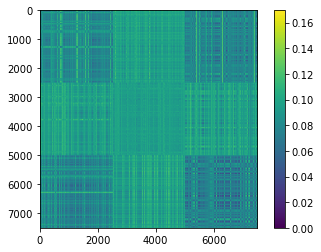

In [149]:
plt.imshow(RMSD)
plt.colorbar()


## Double checking for errors
try pulling the RMSD the most naive way possible

In [193]:
#grab rmsd to reference structure
#note that this is slightly different from rmsd between two optimally aligned conformations
#however it is still justifiable as a dynamical distance

import time
start = time.time()
RMSD = np.zeros((3*len(trajs[0]),3*len(trajs[0])))
Fn = len(trajs[0])
for simi in range(3):
    for framei in range(len(trajs[0])):
        row = Fn*simi+framei
        for simj in range(3):
            rmsd = mdtraj.rmsd(trajs[simi],trajs[simj],frame=framei,atom_indices=selinds[simi],ref_atom_indices=selinds[simj])
            for framej in range(len(trajs[0])):
                col = Fn*simj+framej
                RMSD[row,col] = rmsd[framej]
                
        
end = time.time()
print("time: {}".format(end-start))

time: 35.32871413230896


In [197]:
np.min(RMSD)

0.0

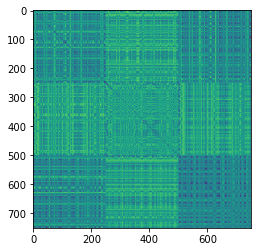

In [194]:
plt.imshow(RMSD)

In [201]:
import MDAnalysis as md
from MDAnalysis.analysis.rms import rmsd

In [214]:
trajcat = np.concatenate((trajs[0].xyz[:,selinds[0],:],trajs[1].xyz[:,selinds[1],:],trajs[2].xyz[:,selinds[2],:]))

In [215]:
trajcat.shape

(750, 9, 3)

In [218]:
import time
start = time.time()

RMSDsilly = np.zeros((3*len(trajs[0]),3*len(trajs[0])))
Fn = len(trajs[0])
for i in range(trajcat.shape[0]):
    for j in range(trajcat.shape[0]):
        r = rmsd(trajcat[i,:,:],trajcat[j,:,:],superposition=True)
        RMSDsilly[i,j] = r
        
end = time.time()
print("time: {}".format(end-start))

time: 21.583836555480957


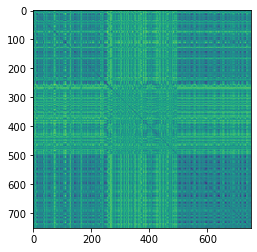

In [219]:
plt.imshow(RMSDsilly)

In [223]:
np.max(RMSDsilly)

0.1665373373665646

## Finding Kernel Bandwidth
To find an approximate kernel bandwidth, we can compute the plot of $\log\left(\sum_{ij} A_{ij}\right)$ versus $\log(\epsilon)$ where $\epsilon$ is the kernal bandwidth of the diffusion map, and $A_{ij} = \exp\left(\frac{-P_{ij}^2}{2\epsilon}\right)$ where $P$ is the matrix of pairwise distances, in this case aligned RMSDs.

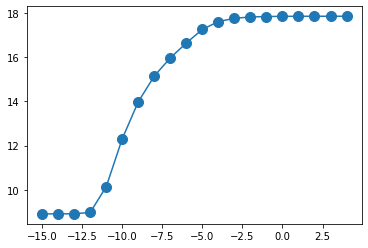

In [68]:

epsilons = np.exp(np.arange(-15,5))
logsumAs = np.zeros(len(epsilons))
i = 0
for epsilon in epsilons:
    A = np.exp(-RMSD*RMSD/(2*epsilon))
    logsumAs[i] = np.log(A.sum())
    i+=1
plt.figure()
plt.plot(np.log(epsilons),logsumAs,'.-',markersize=20)


The slope of the approximately linear region is, as expected, roughly two, even though right now we're running very data-limited just for getting this thing set up quickly.  We choose $\epsilon=e^{-6}$ as an initial guess.

time: 1.9814202785491943


<BarContainer object of 9 artists>

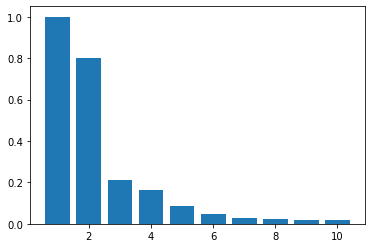

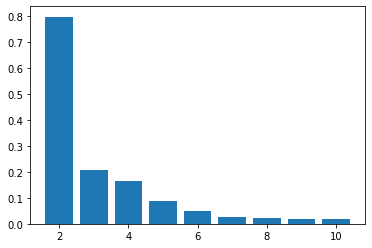

In [120]:
num_evec = 10
epsilon = np.exp(-6)
dmap = PyDMap.DMap()
dmap.set_dists(RMSD[5000:7500,5000:7500])
dmap.set_epsilon(epsilon)
dmap.set_num_evec(num_evec)
start = time.time()
dmap.compute()
end = time.time()
print("time: {}".format(end-start))
evecs = dmap.get_evec()
evals = dmap.get_eval()
plt.figure()
plt.bar(np.arange(num_evec)+1,evals)
plt.figure()
plt.bar(np.arange(1,num_evec)+1,evals[1:])

Shouldn't really have negative eigenvectors...but we are data limited and they're far away from the principal ones...maybe it's okay? Try a different bandwidth to see if we can make the spectral gap a little clearer...

time: 2.415477991104126


<BarContainer object of 9 artists>

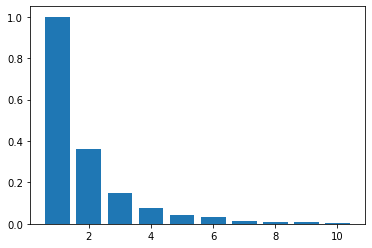

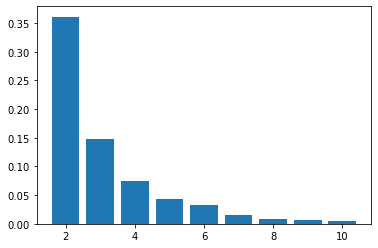

In [107]:
num_evec = 10
epsilon = np.exp(-5)
dmap = PyDMap.DMap()
dmap.set_dists(RMSD[0:2500,0:2500])
dmap.set_epsilon(epsilon)
dmap.set_num_evec(num_evec)
start = time.time()
dmap.compute()
end = time.time()
print("time: {}".format(end-start))
evecs = dmap.get_evec()
evals = dmap.get_eval()
plt.figure()
plt.bar(np.arange(num_evec)+1,evals)
plt.figure()
plt.bar(np.arange(1,num_evec)+1,evals[1:])

In [81]:
subtdatascat = np.concatenate((tdatas[0][0:25000:10],tdatas[1][0:25000:10],tdatas[2][0:25000:10]))

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

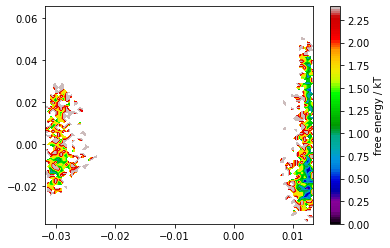

In [121]:
pyemma.plots.plot_free_energy(evecs[0:2500,1],evecs[0:2500,2])
#pyemma.plots.plot_free_energy(evecs[2500:5000,1],evecs[2500:5000,2])
#pyemma.plots.plot_free_energy(evecs[5000:7500,1],evecs[5000:7500,2])

This is weird...could be that I've messed up the pairwise distances and should recompute more explicitly just to see...could be that there isn't enough data...could test on SOLELY one trajectory...or maybe it could be that the GLY is too different...

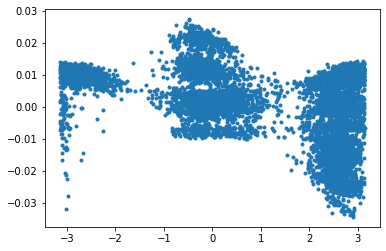

In [85]:
plt.plot(subtdatascat[:,1],evecs[:,1],'.')

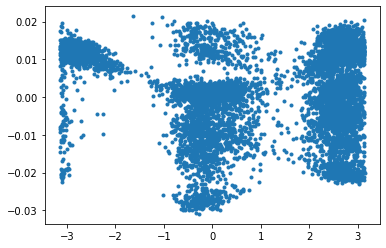

In [86]:
plt.plot(subtdatascat[:,1],evecs[:,2],'.')

In [88]:
from scipy.stats import pearsonr

In [123]:
pearsonr(subtdatascat[5000:7500,1],evecs[:,1])

(0.9177552573972831, 0.0)

In [124]:
pearsonr(subtdatascat[5000:7500,0],evecs[:,2])

(0.9456332031359425, 0.0)

So we pull out the right variable (roughly speaking) if we do the DMap on just dialanine peptide.  What if we throw in the VAL, which seems a little bit better...?  Perhaps we aren't comparing the correct indices or RMSDs?

In [129]:
top = np.concatenate((RMSD[0:2500,0:2500],RMSD[0:2500,5000:7500]),axis=1)
bottom = np.concatenate((RMSD[5000:7500,0:2500],RMSD[5000:7500,5000:7500]),axis=1)
RMSD13 = np.concatenate((top,bottom),axis=0)

time: 7.624279499053955


<BarContainer object of 9 artists>

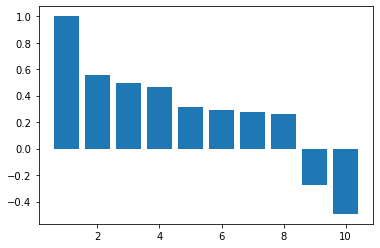

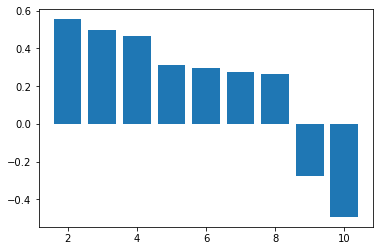

In [132]:
num_evec = 10
epsilon = np.exp(-7)
dmap = PyDMap.DMap()
dmap.set_dists(RMSD13)
dmap.set_epsilon(epsilon)
dmap.set_num_evec(num_evec)
start = time.time()
dmap.compute()
end = time.time()
print("time: {}".format(end-start))
evecs = dmap.get_evec()
evals = dmap.get_eval()
plt.figure()
plt.bar(np.arange(num_evec)+1,evals)
plt.figure()
plt.bar(np.arange(1,num_evec)+1,evals[1:])

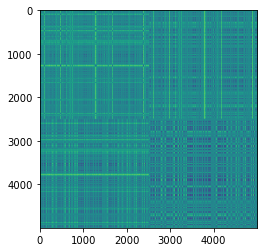

In [133]:
plt.imshow(RMSD13)

In [139]:
pearsonr(subtdatascat[5000:7500,1],evecs[2500:5000,1])

(-0.8741706606118674, 0.0)

In [145]:
pearsonr(subtdatascat[0:2500,1],evecs[:2500,1])

(0.5067532434996914, 3.2334232159087314e-163)

This is kinda confusing...still not sure if i'm getting this...correct? Maybe the RMSDs are wrong...wrong between different proteins?  Upside down?

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

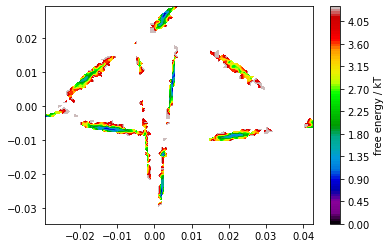

In [148]:
pyemma.plots.plot_free_energy(evecs[:,1],evecs[:,2])

Yeah...definitely not placeing things in the "same" place, probably? some problem with inter-peptide RMSDs, at a guess.